### TODO:
1. Stroke-based rendering
    - painting, 
    - pen-and-ink drawing,     
    - tile mosaics, stippling,  
    - streamline visualization,
    - tensor field visualization.     
        - 

## Architectural decicions
- Stroke data structure
- Image data structure
    - a canvas, defined by a background color or texture,
    and
    - an ordered list of strokes, defined by their parameter
    settings.
- Algorithm for stroke-based rendering
- SBR energy function + abstraction term 

## Models
- Relaxation methods
    - Voronoi algorithms
        - Lloyd’s method
    - trial-and-error algorithms

## Strokes types
### Stripples
A stipple is a stroke that can be described with two parameters: the (x, y) position of
the stipple in an image and the radius r of the stipple.     


100%|██████████| 100/100 [10:11<00:00,  6.12s/it]


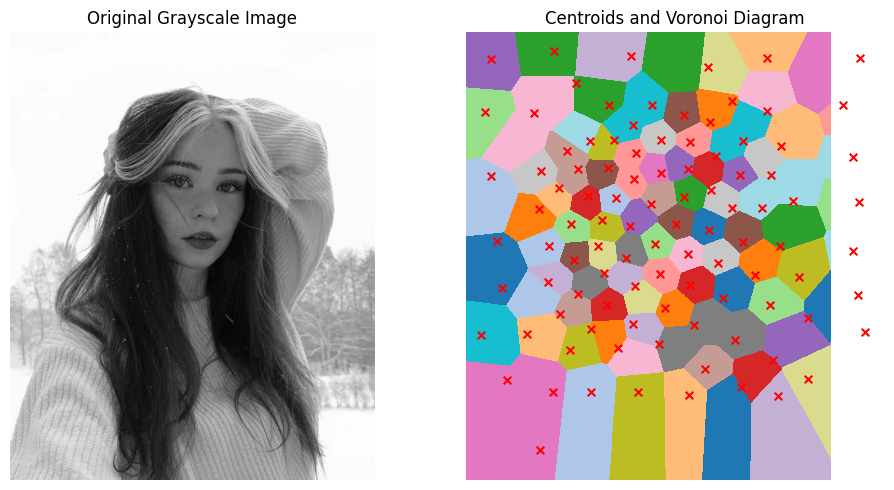

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from tqdm import tqdm

def initialize_centroids(image, n):
    """Randomly initializes centroids within the bounds of the image."""
    height, width = image.shape
    centroids = np.column_stack((
        np.random.uniform(0, width, n),
        np.random.uniform(0, height, n)
    ))
    return centroids

def compute_voronoi_labels(image, centroids):
    """Assigns each pixel to the nearest centroid."""
    height, width = image.shape
    labels = np.zeros((height, width), dtype=int)
    for y in range(height):
        for x in range(width):
            distances = np.linalg.norm(centroids - np.array([x, y]), axis=1)
            labels[y, x] = np.argmin(distances)
    return labels

def update_centroids(image, labels, n_centroids, density_func=None):
    """Recomputes centroids as the mean of the assigned pixel locations."""
    height, width = image.shape
    centroids = np.zeros((n_centroids, 2))
    for i in range(n_centroids):
        pixels = np.argwhere(labels == i)
        if len(pixels) == 0:  # If no pixels are assigned to the centroid
            centroids[i] = np.random.uniform([0, 0], [width, height])  # Reinitialize randomly
        else:
            if density_func is not None:
                weights = density_func(image[pixels[:, 0], pixels[:, 1]])
                weights = weights + 1e-8  # Ensure weights are non-zero
                centroids[i] = np.average(pixels, axis=0, weights=weights)
            else:
                centroids[i] = pixels.mean(axis=0)
    return centroids


def lloyds_method(image, n_centroids, density_func=None, max_iter=100, tol=1e-4):
    """Performs Lloyd's method to optimize centroid placement."""
    centroids = initialize_centroids(image, n_centroids)
    prev_energy = float('inf')

    for iteration in tqdm(range(max_iter)):
        labels = compute_voronoi_labels(image, centroids)
        new_centroids = update_centroids(image, labels, n_centroids, density_func)
        energy = compute_energy(image, labels, centroids, density_func)

        if np.abs(prev_energy - energy) < tol:
            print(f"Converged after {iteration + 1} iterations.")
            break

        centroids = new_centroids
        prev_energy = energy

    return centroids, labels

def compute_energy(image, labels, centroids, density_func=None):
    """Calculates the energy function for the current configuration."""
    energy = 0
    for i, centroid in enumerate(centroids):
        pixels = np.argwhere(labels == i)
        distances = np.linalg.norm(pixels - centroid, axis=1)
        if density_func is not None:
            energy += np.sum(density_func(image[pixels[:, 0], pixels[:, 1]]) * distances**2)
        else:
            energy += np.sum(distances**2)
    return energy

# Example usage
if __name__ == "__main__":
    # Load and preprocess the image
    image_path = "../_demo/images/img.png"  # Replace with the path to your PNG image
    original_image = io.imread(image_path)
    grayscale_image = color.rgb2gray(original_image)  # Convert to grayscale
    normalized_image = (grayscale_image - grayscale_image.min()) / (grayscale_image.max() - grayscale_image.min())  # Normalize to [0, 1]

    # Density function example based on grayscale intensity
    def density_function(pixel_values):
        return 1 - pixel_values + 1e-8  # Invert intensity for density

    # Run Lloyd's method
    num_centroids = 100  # Adjust the number of centroids
    centroids, labels = lloyds_method(normalized_image, num_centroids, density_function)

    # Visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(grayscale_image, cmap="gray")
    plt.title("Original Grayscale Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(labels, cmap="tab20", interpolation="nearest")
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=30)
    plt.title("Centroids and Voronoi Diagram")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


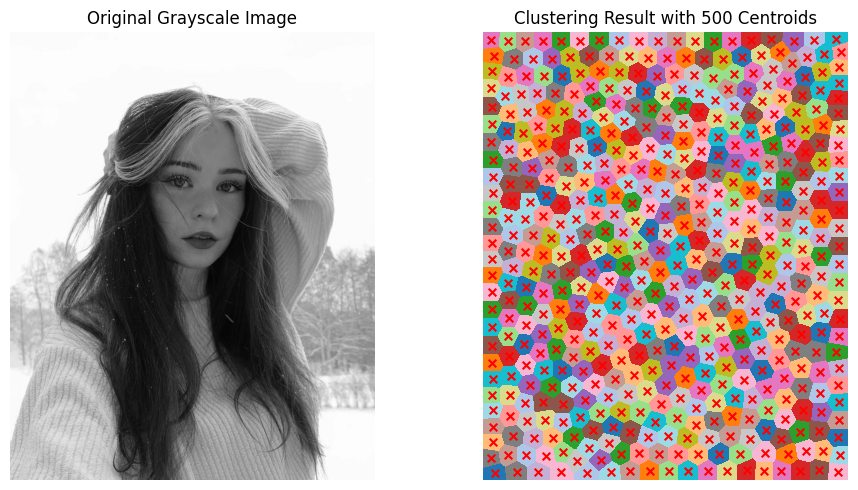

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from sklearn.cluster import KMeans

def load_and_preprocess_image(image_path):
    """Load a PNG image, convert to grayscale, and normalize."""
    original_image = io.imread(image_path)
    grayscale_image = color.rgb2gray(original_image)  # Convert to grayscale
    normalized_image = (grayscale_image - grayscale_image.min()) / (grayscale_image.max() - grayscale_image.min())  # Normalize to [0, 1]
    return normalized_image

def prepare_data_for_clustering(image):
    """Prepare pixel coordinates and intensity values for clustering."""
    height, width = image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    coordinates = np.column_stack((x.ravel(), y.ravel()))
    intensities = image.ravel()
    data = np.column_stack((coordinates, intensities))  # Combine coordinates and intensity
    return data

def visualize_results(image, centroids, labels, num_centroids):
    """Visualize the original image and clustering results."""
    height, width = image.shape
    labeled_image = labels.reshape(height, width)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Grayscale Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(labeled_image, cmap="tab20", interpolation="nearest")
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=30)
    plt.title(f"Clustering Result with {num_centroids} Centroids")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Main function
if __name__ == "__main__":
    # Load and preprocess the image
    image_path = "../_demo/images/img.png"  # Replace with the path to your PNG image
    grayscale_image = load_and_preprocess_image(image_path)

    # Prepare data for clustering
    data = prepare_data_for_clustering(grayscale_image)

    # Run k-means clustering using scikit-learn
    num_centroids = 500  # Number of clusters/centroids
    kmeans = KMeans(n_clusters=num_centroids, init="k-means++", random_state=42)
    kmeans.fit(data)

    # Retrieve clustering results
    centroids = kmeans.cluster_centers_[:, :2]  # Centroid coordinates
    labels = kmeans.labels_  # Labels for each pixel

    # Visualize results
    visualize_results(grayscale_image, centroids, labels, num_centroids)


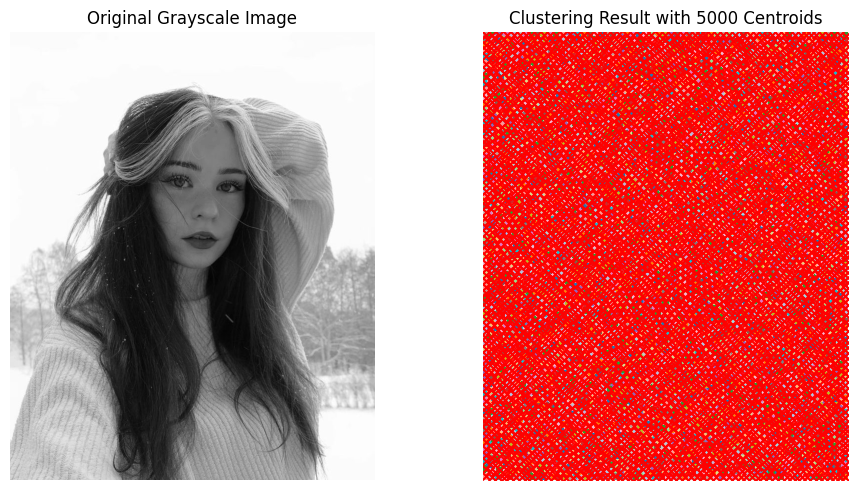

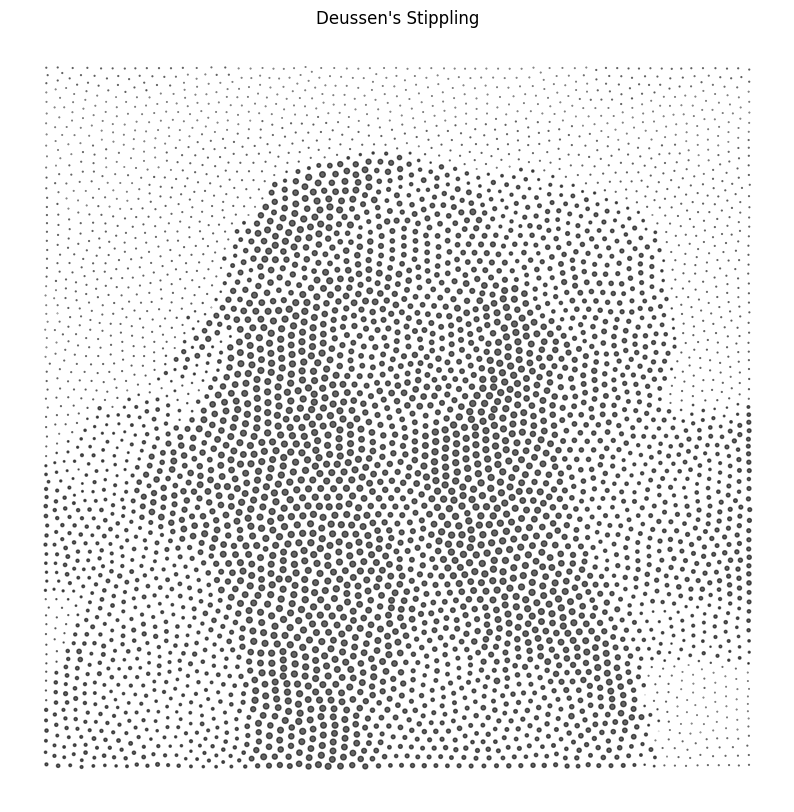

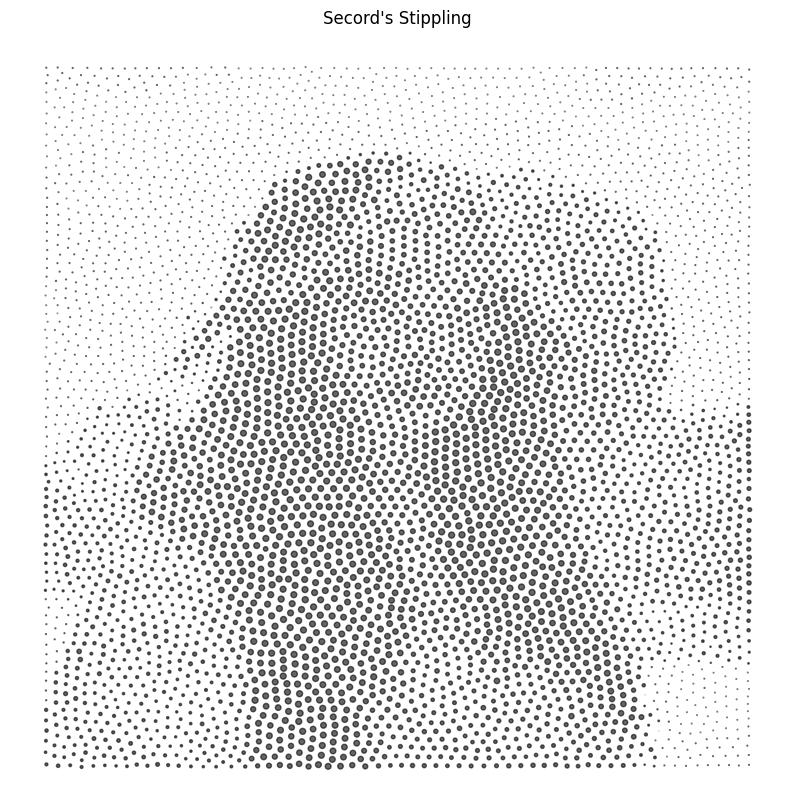

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from sklearn.cluster import KMeans

def load_and_preprocess_image(image_path):
    """Load a PNG image, convert to grayscale, and normalize."""
    original_image = io.imread(image_path)
    grayscale_image = color.rgb2gray(original_image)
    normalized_image = (grayscale_image - grayscale_image.min()) / (grayscale_image.max() - grayscale_image.min())
    return normalized_image

def prepare_data_for_clustering(image):
    """Prepare pixel coordinates and intensity values for clustering."""
    height, width = image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    coordinates = np.column_stack((x.ravel(), y.ravel()))
    intensities = image.ravel()
    data = np.column_stack((coordinates, intensities))  # Combine coordinates and intensity
    return data

def deussen_stippling(image, centroids):
    """Deussen's method: Varying stipple size based on gray levels."""
    sizes = (1 - image[centroids[:, 1].astype(int), centroids[:, 0].astype(int)]) * 20  # Scale stipple size
    return sizes

def secord_stippling(image, centroids):
    """Secord's method: Varying dot density based on intensity."""
    max_gray = image.max()
    density = 1 - image / max_gray
    sizes = density[centroids[:, 1].astype(int), centroids[:, 0].astype(int)] * 20  # Scale stipple size by density
    return sizes

def visualize_stippling(image, centroids, sizes, method_name):
    """Visualize the stippling result."""
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap="gray")
    plt.scatter(centroids[:, 0], centroids[:, 1], s=sizes, c='black', alpha=0.6)
    plt.title(f"{method_name} Stippling")
    plt.axis("off")
    plt.show()
    
def visualize_stippling_only(centroids, sizes, method_name):
    """Visualize stippling result with dots only."""
    plt.figure(figsize=(10, 10))
    plt.scatter(centroids[:, 0], centroids[:, 1], s=sizes, c='black', alpha=0.6)
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.title(f"{method_name} Stippling")
    plt.axis("off")
    plt.show()


# Main function
if __name__ == "__main__":
    # Load and preprocess the image
    image_path = "../_demo/images/img.png"  # Replace with your image file path
    grayscale_image = load_and_preprocess_image(image_path)

    # Prepare data for clustering
    data = prepare_data_for_clustering(grayscale_image)

    # Run k-means clustering
    num_centroids = 5000  # Number of stipples
    kmeans = KMeans(n_clusters=num_centroids, init="k-means++", random_state=42)
    kmeans.fit(data)

    # Retrieve centroids
    centroids = kmeans.cluster_centers_[:, :2]  # Centroid coordinates
    
    # visualize_results(grayscale_image, centroids, labels, num_centroids)
    
    labels = kmeans.labels_  # Labels for each pixel

    # Visualize results
    visualize_results(grayscale_image, centroids, labels, num_centroids)
    # Deussen's method
    deussen_sizes = deussen_stippling(grayscale_image, centroids)
    # visualize_stippling(grayscale_image, centroids, deussen_sizes, "Deussen's")
    visualize_stippling_only(centroids, deussen_sizes, "Deussen's")

    # Secord's method
    secord_sizes = secord_stippling(grayscale_image, centroids)
    # visualize_stippling(grayscale_image, centroids, secord_sizes, "Secord's")
    visualize_stippling_only(centroids, secord_sizes, "Secord's")


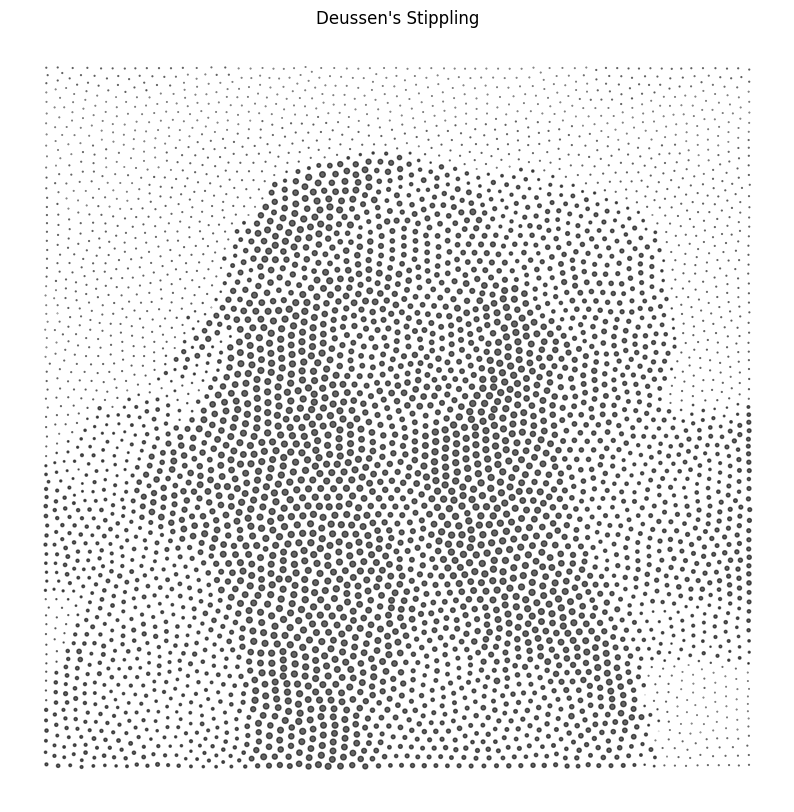

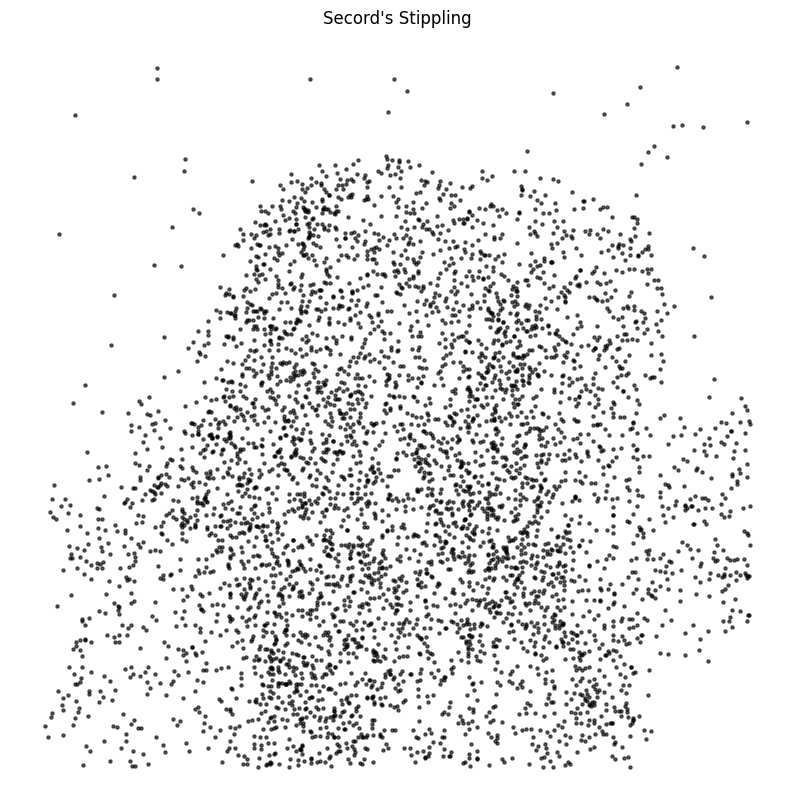

In [12]:
def deussen_rendering(image, centroids):
    """Deussen's method: Size-based stippling."""
    sizes = (1 - image[centroids[:, 1].astype(int), centroids[:, 0].astype(int)]) * 20  # Scale stipple size
    return sizes

def secord_rendering(image, num_centroids):
    """Secord's method: Spacing-based stippling with uniform size."""
    # Derive density function: ρ(p) = 1 - T(p) / max_gray
    max_gray = image.max()
    density_function = 1 - image / max_gray
    # Sample points based on density
    height, width = image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    pixel_coords = np.column_stack((x.ravel(), y.ravel()))
    density_values = density_function.ravel()

    # Normalize density values for rejection sampling
    density_values /= density_values.sum()

    # Select points proportional to density values
    sampled_indices = np.random.choice(np.arange(pixel_coords.shape[0]), size=num_centroids, p=density_values)
    sampled_points = pixel_coords[sampled_indices]
    return sampled_points

def visualize_stippling(centroids, sizes, method_name, uniform_size=False):
    """Visualize stippling result."""
    plt.figure(figsize=(10, 10))
    if uniform_size:
        plt.scatter(centroids[:, 0], centroids[:, 1], s=5, c='black', alpha=0.6)
    else:
        plt.scatter(centroids[:, 0], centroids[:, 1], s=sizes, c='black', alpha=0.6)
    plt.gca().invert_yaxis()  # Match image coordinates
    plt.title(f"{method_name} Stippling")
    plt.axis("off")
    plt.show()
    
    
deussen_sizes = deussen_rendering(grayscale_image, centroids)
visualize_stippling(centroids, deussen_sizes, "Deussen's", uniform_size=False)

# Secord's Method
secord_centroids = secord_rendering(grayscale_image, num_centroids)
visualize_stippling(secord_centroids, sizes=None, method_name="Secord's", uniform_size=True)

Image shape: (902, 735)
Dithered image shape: (902, 735)
Initial centroids shape: (5000, 2)


IndexError: index 772 is out of bounds for axis 1 with size 735

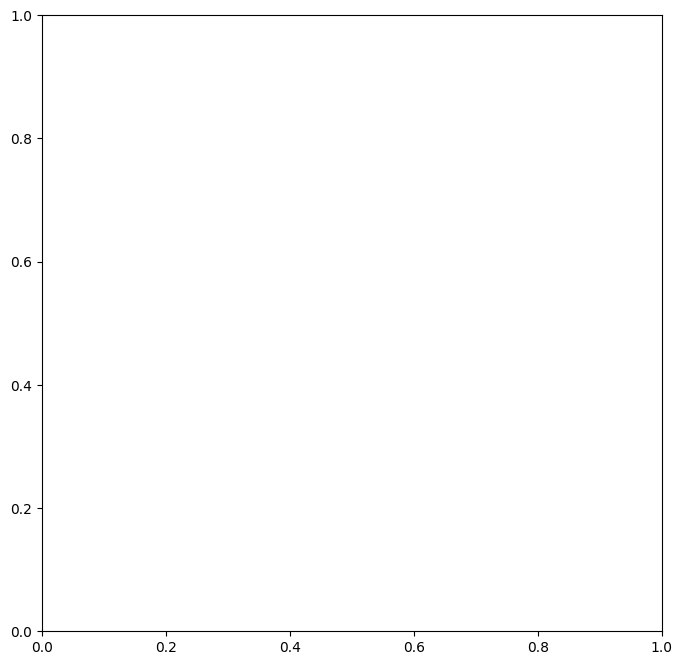

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def preprocess_image(image):
    """Enhance image contrast and normalize grayscale intensity."""
    enhanced_image = cv2.equalizeHist(image)  # Improve contrast
    normalized_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX)  # Normalize
    return normalized_image

def floyd_steinberg_dithering(image):
    """Apply Floyd-Steinberg dithering to initialize centroids."""
    dithered = np.copy(image)
    for y in range(image.shape[0] - 1):
        for x in range(1, image.shape[1] - 1):
            old_pixel = dithered[y, x]
            new_pixel = 255 * (old_pixel > 127)
            dithered[y, x] = new_pixel
            quant_error = old_pixel - new_pixel
            dithered[y, x + 1] += quant_error * 7 / 16
            dithered[y + 1, x - 1] += quant_error * 3 / 16
            dithered[y + 1, x] += quant_error * 5 / 16
            dithered[y + 1, x + 1] += quant_error * 1 / 16
    return dithered

def lloyd_optimized(image, num_centroids, max_iter=20):
    """Enhanced Lloyd's method with adaptive iterations."""
    points = np.column_stack(np.nonzero(image))
    kmeans = KMeans(n_clusters=num_centroids, max_iter=max_iter, random_state=42, n_init=10)
    kmeans.fit(points)
    centroids = kmeans.cluster_centers_
    return centroids

def deussen_stippling(image, centroids):
    """Deussen's stippling with adaptive dot sizes."""
    max_gray = image.max()
    plt.figure(figsize=(8, 8))
    for cx, cy in centroids:
        gray_level = image[int(cy), int(cx)]
        radius = (1 - gray_level / max_gray) * 5 + 1  # Proportional to intensity
        circle = plt.Circle((cx, cy), radius, color='black', fill=True)
        plt.gca().add_artist(circle)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.title("Deussen's Stippling")
    plt.show()

def secord_stippling(image, centroids):
    """Secord's stippling with adaptive density."""
    max_gray = image.max()
    plt.figure(figsize=(8, 8))
    for cx, cy in centroids:
        gray_level = image[int(cy), int(cx)]
        if np.random.rand() < (1 - gray_level / max_gray):
            plt.scatter(cx, cy, color='black', s=1)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.title("Secord's Stippling")
    plt.show()

def blended_stippling(image, centroids):
    """Blend Deussen's varying sizes and Secord's varying density."""
    max_gray = image.max()
    plt.figure(figsize=(8, 8))
    for cx, cy in centroids:
        gray_level = image[int(cy), int(cx)]
        radius = (1 - gray_level / max_gray) * 5 + 1
        density_factor = 1 - gray_level / max_gray
        if np.random.rand() < density_factor:
            circle = plt.Circle((cx, cy), radius, color='black', fill=True)
            plt.gca().add_artist(circle)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.title("Blended Stippling")
    plt.show()

# Load and preprocess the image
image_path = "../_demo/images/img.png"
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
processed_image = preprocess_image(original_image)
print("Image shape:", processed_image.shape)

# Initialize centroids
dithered_image = floyd_steinberg_dithering(processed_image)
print("Dithered image shape:", dithered_image.shape)
initial_centroids = lloyd_optimized(dithered_image, num_centroids=5000, max_iter=30)
print("Initial centroids shape:", initial_centroids.shape)

# Render stippling
deussen_stippling(processed_image, initial_centroids)
print("Deussen's method:")
secord_stippling(processed_image, initial_centroids)
print("Secord's method:")
blended_stippling(processed_image, initial_centroids)
print("Blended method:")
